<H1>Task 03 - Predictive analytics for Optimal School Location Finder Geospatial Application</H1>

In [1]:
# Install these libraries if you don't have them already
"""
!pip install pandas
!pip install geopandas
!pip install matplotlib
!pip install folium
!pip install geopy
!pip install scikit-learn
!pip install pysal
!pip install seaborn
!pip install mpl_toolkits
"""

'\n!pip install pandas\n!pip install geopandas\n!pip install matplotlib\n!pip install folium\n!pip install geopy\n!pip install scikit-learn\n!pip install pysal\n!pip install seaborn\n!pip install mpl_toolkits\n'

In [2]:
# Required python libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from pysal.explore import esda
from pysal.lib import weights
from pysal.viz import splot
from splot.esda import moran_scatterplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


<H2>Spatial Data Collection</H2>

<H3>Location Availability Analysis</H3>

Analyze the Non-utilized lands in the Monaragala, Buttala, Badalkumbura, and Wellawaya Divisions using Google Maps Satelite View.

In [3]:
# Read the data files

# Path to the CSV file
locations_csv_file_path = 'data_files/locations.csv'
population_csv_file_path = 'data_files/population.csv'
age_csv_file_path = 'data_files/age_distribution.csv'
city_csv_file_path = 'data_files/city.csv'
hospitals_csv_file_path = 'data_files/hospitals.csv'
police_csv_file_path = 'data_files/police_stations.csv'
schools_csv_file_path = 'data_files/schools.csv'
weather_csv_file_path = 'data_files/weather.csv'

# Read the CSV file into a DataFrame
locations_df = pd.read_csv(locations_csv_file_path)
population_df = pd.read_csv(population_csv_file_path)
age_df = pd.read_csv(age_csv_file_path)
city_df = pd.read_csv(city_csv_file_path)
hospitals_df = pd.read_csv(hospitals_csv_file_path)
police_df = pd.read_csv(police_csv_file_path)
schools_df = pd.read_csv(schools_csv_file_path)
weather_df = pd.read_csv(weather_csv_file_path)

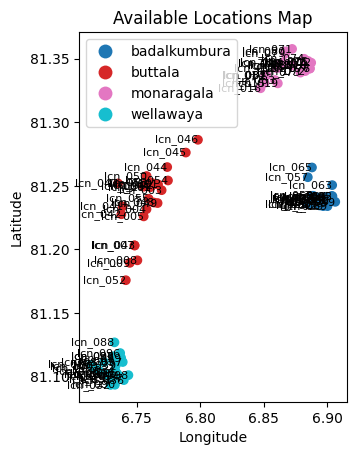

In [4]:
# Visualize the Selected Available Location for Model development

# Create a GeoDataFrame using longitude and latitude columns
geo_locations_df = gpd.GeoDataFrame(locations_df, geometry=gpd.points_from_xy(locations_df.longitude, locations_df.latitude))

# Set up the plot to display the GeoDataFrame
fig, ax = plt.subplots()
# Plot the GeoDataFrame on the axes with a column mapping divisions to colors
geo_locations_df.plot(ax=ax, column='division', legend=True, legend_kwds={'loc': 'upper left'})

# Add labels to the plot for each location
for x, y, label in zip(geo_locations_df.geometry.x, geo_locations_df.geometry.y, geo_locations_df['location_id']):
    ax.text(x, y, str(label), fontsize=8, ha='right', va='center')

# Set the x and y axes labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Available Locations Map')
plt.show()

# Set the initial location to Sri Lanka  
initial_location = [7.8731, 80.7718]
# Create a folium map centered at the initial location 
location_map = folium.Map(location=initial_location, zoom_start=8)

# Create a mapping of divisions to colors 
color_mapping = {
    'monaragala': 'red',
    'buttala': 'blue',
    'badalkumbura': 'green',
    'wellawaya': 'purple',
}

# Add a marker for each location to the map with a color based on the division
for index, row in locations_df.iterrows():
    division_color = color_mapping.get(row['division'].lower(), 'gray') 
    folium.Marker(
        location=[row['longitude'], row['latitude']],
        popup=f"Location ID: {row['location_id']}",
        icon=folium.Icon(color=division_color)
    ).add_to(location_map)

# Save the map as an HTML file
location_map.save('maps/selected_locations_map.html')
location_map

<H4>To identify the most optimal location for establishing a new school, I extracted the following data types</H4>

- Location availability
- Population density
- Age distribution (Age < 19)
- Locations of existing schools
- Road network (Distance to the nearest main road (A Grade))
- Locations of police stations
- Locations of hospitals
- Distance to nearest City
- Weather data

<H2>Spatial Data Pre-processing</H2>

<H3>Merge the population density with Selected Available Locations</H3>

In [5]:

# Merge only the 'population_density' column based on the 'division' column
locations_df = pd.merge(locations_df, population_df[['division', 'population_density']], on='division', how='left')

# Display the resulting dataframe
print(locations_df.head())

  location_id division  longitude   latitude  dist_to_main_road  \
0     lcn_001  buttala   6.761014  81.248930                  2   
1     lcn_002  buttala   6.762943  81.250759                  2   
2     lcn_003  buttala   6.769758  81.246575               1200   
3     lcn_004  buttala   6.757871  81.231635                250   
4     lcn_005  buttala   6.755652  81.225967                170   

   population_density  
0               74.66  
1               74.66  
2               74.66  
3               74.66  
4               74.66  


<H3>Identify the number of students (Age < 19) in the each division</H3>

<H4>Calculate the student density</H4>

- Student Density = Number of Students in a each division/ Area

In [6]:
# Calculate student density
def calculate_student_density(age_df, population_df, locations_df):

    # Calculate the sum of '0_9_years' and '10_19_years' columns
    age_df['no_of_students'] = age_df['0_9_years'] + age_df['10_19_years']

    # Merge dataframes based on the 'division' column
    population_df = pd.merge(population_df, age_df[['division', 'no_of_students']], on='division', how='left')

    # Calculate the student_density and include it as a new column
    population_df['student_density'] = population_df['no_of_students'] / population_df['area']

    # Merge the 'student_density' column based on the 'division' column
    locations_df = pd.merge(locations_df, population_df[['division', 'student_density']], on='division', how='left')

    return locations_df

# Call the function to calculate the student density
locations_df = calculate_student_density(age_df, population_df, locations_df)

print(locations_df.head())

locations_df.head()

  location_id division  longitude   latitude  dist_to_main_road  \
0     lcn_001  buttala   6.761014  81.248930                  2   
1     lcn_002  buttala   6.762943  81.250759                  2   
2     lcn_003  buttala   6.769758  81.246575               1200   
3     lcn_004  buttala   6.757871  81.231635                250   
4     lcn_005  buttala   6.755652  81.225967                170   

   population_density  student_density  
0               74.66        25.722925  
1               74.66        25.722925  
2               74.66        25.722925  
3               74.66        25.722925  
4               74.66        25.722925  


,location_id,division,longitude,latitude,dist_to_main_road,population_density,student_density
0,lcn_001,buttala,6.761014,81.248930,2,74.66,25.722925
1,lcn_002,buttala,6.762943,81.250759,2,74.66,25.722925
2,lcn_003,buttala,6.769758,81.246575,1200,74.66,25.722925
3,lcn_004,buttala,6.757871,81.231635,250,74.66,25.722925
4,lcn_005,buttala,6.755652,81.225967,170,74.66,25.722925


<H3>Nearest school identification</H3>

Calculate the distance (KM) to the schools in the division for each selected available location.

Identify the nearest school for each location based on the minimum distance.

Import geodesic from geopy.distance

Vincenty formular is used for calculate the distance between two geo location points.

In [7]:
# Identify the nearest school to each location
def find_nearest_school(locations_df, schools_df):
    # Initialize the column to locations_df dataframe
    locations_df['nearest_school_name'] = ''
    locations_df['school_distance'] = 0.0

    # Iterate over each row in locations_df
    for index, location in locations_df.iterrows():
        division = location['division']
        location_coords = (location['latitude'], location['longitude'])

        # Filter schools_df records for the current division
        division_schools = schools_df[schools_df['division'] == division]

        # Calculate distances to each school using Vincenty formula
        distances = division_schools.apply(
            lambda school: geodesic(location_coords, (school['scl_latitude'], school['scl_longitude'])).km, axis=1
        )

        # Find the index of the nearest school
        nearest_school_index = distances.idxmin()

        # Update the nearest school name and distance columns
        locations_df.at[index, 'nearest_school_name'] = schools_df.at[nearest_school_index, 'scl_name']
        locations_df.at[index, 'school_distance'] = distances[nearest_school_index]

    return locations_df

# Call the function to find the nearest school
locations_df = find_nearest_school(locations_df, schools_df)

print(locations_df.head())

locations_df.head()

  location_id division  longitude   latitude  dist_to_main_road  \
0     lcn_001  buttala   6.761014  81.248930                  2   
1     lcn_002  buttala   6.762943  81.250759                  2   
2     lcn_003  buttala   6.769758  81.246575               1200   
3     lcn_004  buttala   6.757871  81.231635                250   
4     lcn_005  buttala   6.755652  81.225967                170   

   population_density  student_density              nearest_school_name  \
0               74.66        25.722925               Dutugemunu College   
1               74.66        25.722925               Dutugemunu College   
2               74.66        25.722925               Dutugemunu College   
3               74.66        25.722925  Dutugamunu model primary school   
4               74.66        25.722925   Yudhaganawa Kanishta Vidyalaya   

   school_distance  
0         0.234081  
1         0.438155  
2         0.136805  
3         0.387106  
4         0.305142  


,location_id,division,longitude,latitude,dist_to_main_road,population_density,student_density,nearest_school_name,school_distance
0,lcn_001,buttala,6.761014,81.248930,2,74.66,25.722925,Dutugemunu College,0.234081
1,lcn_002,buttala,6.762943,81.250759,2,74.66,25.722925,Dutugemunu College,0.438155
2,lcn_003,buttala,6.769758,81.246575,1200,74.66,25.722925,Dutugemunu College,0.136805
3,lcn_004,buttala,6.757871,81.231635,250,74.66,25.722925,Dutugamunu model primary school,0.387106
4,lcn_005,buttala,6.755652,81.225967,170,74.66,25.722925,Yudhaganawa Kanishta Vidyalaya,0.305142


<H3>Nearest Police Station identification</H3>

Calculate the distance (KM) to the police stations in the division for each selected available location.

Identify the nearest police station for each location based on the minimum distance.

Import geodesic from geopy.distance

Vincenty formular is used for calculate the distance between two geo location points.

In [8]:
# Identify the nearest police station to each location
def find_nearest_police_station(locations_df, police_df):
    # Initialize the column to locations_df dataframe
    locations_df['nearest_police_station'] = ''
    locations_df['police_distance'] = 0.0

    # Iterate over each row in locations_df
    for index, location in locations_df.iterrows():
        division = location['division']
        location_coords = (location['latitude'], location['longitude'])

        # Filter police_df records for the current division
        division_polices = police_df[police_df['division'] == division]

        # Calculate distances to each police station using Vincenty formula
        distances = division_polices.apply(
            lambda police: geodesic(location_coords, (police['police_latitude'], police['police_longitude'])).km,
            axis=1
        )

        # Find the index of the nearest police station
        nearest_police_index = distances.idxmin()

        # Update the nearest police station name and distance columns
        locations_df.at[index, 'nearest_police_station'] = police_df.at[nearest_police_index, 'police_station']
        locations_df.at[index, 'police_distance'] = distances[nearest_police_index]

    return locations_df

locations_df = find_nearest_police_station(locations_df, police_df)

print(locations_df.head())

  location_id division  longitude   latitude  dist_to_main_road  \
0     lcn_001  buttala   6.761014  81.248930                  2   
1     lcn_002  buttala   6.762943  81.250759                  2   
2     lcn_003  buttala   6.769758  81.246575               1200   
3     lcn_004  buttala   6.757871  81.231635                250   
4     lcn_005  buttala   6.755652  81.225967                170   

   population_density  student_density              nearest_school_name  \
0               74.66        25.722925               Dutugemunu College   
1               74.66        25.722925               Dutugemunu College   
2               74.66        25.722925               Dutugemunu College   
3               74.66        25.722925  Dutugamunu model primary school   
4               74.66        25.722925   Yudhaganawa Kanishta Vidyalaya   

   school_distance  nearest_police_station  police_distance  
0         0.234081  Buttala Police Station         0.168093  
1         0.438155  Bu

<H3>Nearest Hospital identification</H3>

Calculate the distance (KM) to the hospital in the division for each selected available location.

Identify the nearest hospital for each location based on the minimum distance.

Import geodesic from geopy.distance

Vincenty formular is used for calculate the distance between two geo location points.

In [9]:
# Identify the nearest hospital to each location
def find_nearest_hospital(locations_df, hospitals_df):
    # Initialize the column to locations_df dataframe
    locations_df['nearest_hospital_name'] = ''
    locations_df['hospital_distance'] = 0.0

    # Iterate over each row in locations_df
    for index, location in locations_df.iterrows():
        division = location['division']
        location_coords = (location['latitude'], location['longitude'])

        # Filter hospitals_df records for the current division
        division_hospitals = hospitals_df[hospitals_df['division'] == division]

        # Calculate distances to each hospital using Vincenty formula
        distances = division_hospitals.apply(
            lambda hospital: geodesic(location_coords, (hospital['hospital_latitude'], hospital['hospital_longitude'])).km,
            axis=1
        )

        # Find the index of the nearest hospital
        nearest_hospital_index = distances.idxmin()

        # Update the nearest hospital name and distance columns
        locations_df.at[index, 'nearest_hospital_name'] = hospitals_df.at[nearest_hospital_index, 'hospital']
        locations_df.at[index, 'hospital_distance'] = distances[nearest_hospital_index]

    return locations_df

locations_df = find_nearest_hospital(locations_df, hospitals_df)

print(locations_df.head())

  location_id division  longitude   latitude  dist_to_main_road  \
0     lcn_001  buttala   6.761014  81.248930                  2   
1     lcn_002  buttala   6.762943  81.250759                  2   
2     lcn_003  buttala   6.769758  81.246575               1200   
3     lcn_004  buttala   6.757871  81.231635                250   
4     lcn_005  buttala   6.755652  81.225967                170   

   population_density  student_density              nearest_school_name  \
0               74.66        25.722925               Dutugemunu College   
1               74.66        25.722925               Dutugemunu College   
2               74.66        25.722925               Dutugemunu College   
3               74.66        25.722925  Dutugamunu model primary school   
4               74.66        25.722925   Yudhaganawa Kanishta Vidyalaya   

   school_distance  nearest_police_station  police_distance  \
0         0.234081  Buttala Police Station         0.168093   
1         0.438155  

<H3>Distance to Nearest Town Center</H3>

Calculate the distance (KM) to the Town in the division for each selected available location.

Identify the nearest Town for each location based on the minimum distance.

Import geodesic from geopy.distance

Vincenty formular is used for calculate the distance between two geo location points.

In [10]:
# Identify nearest city to each location
def find_nearest_city(locations_df, city_df):
    # Initialize the column to locations_df dataframe
    locations_df['nearest_city_name'] = ''
    locations_df['city_distance'] = 0.0

    # Iterate over each row in locations_df
    for index, location in locations_df.iterrows():
        division = location['division']
        location_coords = (location['latitude'], location['longitude'])

        # Filter city_df records for the current division
        division_city = city_df[city_df['division'] == division]

        # Calculate distances to the city center using Vincenty formula
        distances = division_city.apply(
            lambda city: geodesic(location_coords, (city['city_latitude'], city['city_longitude'])).km, axis=1
        )

        # Find the index of the nearest city
        nearest_city_index = distances.idxmin()

        # Update the nearest city name and distance columns
        locations_df.at[index, 'nearest_city_name'] = city_df.at[nearest_city_index, 'city']
        locations_df.at[index, 'city_distance'] = distances[nearest_city_index]

    return locations_df

locations_df = find_nearest_city(locations_df, city_df)

print(locations_df.head())

  location_id division  longitude   latitude  dist_to_main_road  \
0     lcn_001  buttala   6.761014  81.248930                  2   
1     lcn_002  buttala   6.762943  81.250759                  2   
2     lcn_003  buttala   6.769758  81.246575               1200   
3     lcn_004  buttala   6.757871  81.231635                250   
4     lcn_005  buttala   6.755652  81.225967                170   

   population_density  student_density              nearest_school_name  \
0               74.66        25.722925               Dutugemunu College   
1               74.66        25.722925               Dutugemunu College   
2               74.66        25.722925               Dutugemunu College   
3               74.66        25.722925  Dutugamunu model primary school   
4               74.66        25.722925   Yudhaganawa Kanishta Vidyalaya   

   school_distance  nearest_police_station  police_distance  \
0         0.234081  Buttala Police Station         0.168093   
1         0.438155  

<H3>Merge the Weather Data with Selected Available Locations</H3>

Weather data is obtained from the 'weatherandclimate' online sources (https://weatherandclimate.com/)

- Average annual precipitation (mm)

- Annual Average high temperature (ºC)	

- Mean monthly sunshine hours per annum	

In [11]:
# Merge columns from weather_df into locations_df based on the 'division' column
locations_df = pd.merge(locations_df, weather_df[['division', 'annual_precipitation', 'avg_high_temp', 'sunshine_hours']], on='division', how='left')

print(locations_df.head())

  location_id division  longitude   latitude  dist_to_main_road  \
0     lcn_001  buttala   6.761014  81.248930                  2   
1     lcn_002  buttala   6.762943  81.250759                  2   
2     lcn_003  buttala   6.769758  81.246575               1200   
3     lcn_004  buttala   6.757871  81.231635                250   
4     lcn_005  buttala   6.755652  81.225967                170   

   population_density  student_density              nearest_school_name  \
0               74.66        25.722925               Dutugemunu College   
1               74.66        25.722925               Dutugemunu College   
2               74.66        25.722925               Dutugemunu College   
3               74.66        25.722925  Dutugamunu model primary school   
4               74.66        25.722925   Yudhaganawa Kanishta Vidyalaya   

   school_distance  nearest_police_station  police_distance  \
0         0.234081  Buttala Police Station         0.168093   
1         0.438155  

In [12]:
locations_df.info()
locations_df
# Save the locations_df dataframe to a CSV file
locations_df.to_csv('data_files/locations_processed.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   location_id             100 non-null    object 
 1   division                100 non-null    object 
 2   longitude               100 non-null    float64
 3   latitude                100 non-null    float64
 4   dist_to_main_road       100 non-null    int64  
 5   population_density      100 non-null    float64
 6   student_density         100 non-null    float64
 7   nearest_school_name     100 non-null    object 
 8   school_distance         100 non-null    float64
 9   nearest_police_station  100 non-null    object 
 10  police_distance         100 non-null    float64
 11  nearest_hospital_name   100 non-null    object 
 12  hospital_distance       100 non-null    float64
 13  nearest_city_name       100 non-null    object 
 14  city_distance           100 non-null    flo

<H2>Spatial Exploratory Data Analysis (ESDA)</H2>

<H3>Spatial Autocorrelation Analysis</H3>

Use a spatial statistics library PySAL (Python Spatial Analysis Library) to calculate Moran's I. 

Calculate Moran's I for population density, student density to assess whether there is spatial autocorrelation. Identify areas where similar values cluster spatially.

In [13]:
# Create a geometry column from lng & lat
geometry = gpd.points_from_xy(locations_df['longitude'], locations_df['latitude']) 
location_geo_df = gpd.GeoDataFrame(locations_df, geometry=geometry)

Moran's I for population_density: 0.9268969925595197
P-value: 0.001



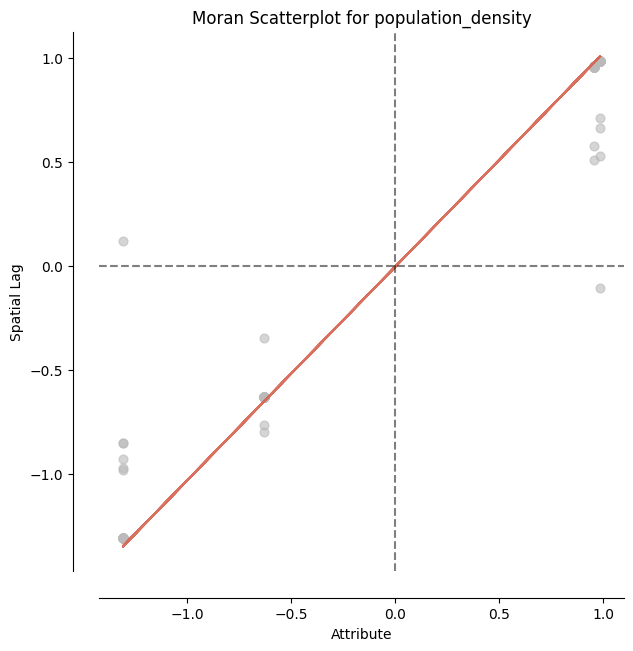

Moran's I for student_density: 0.9268619316694398
P-value: 0.001



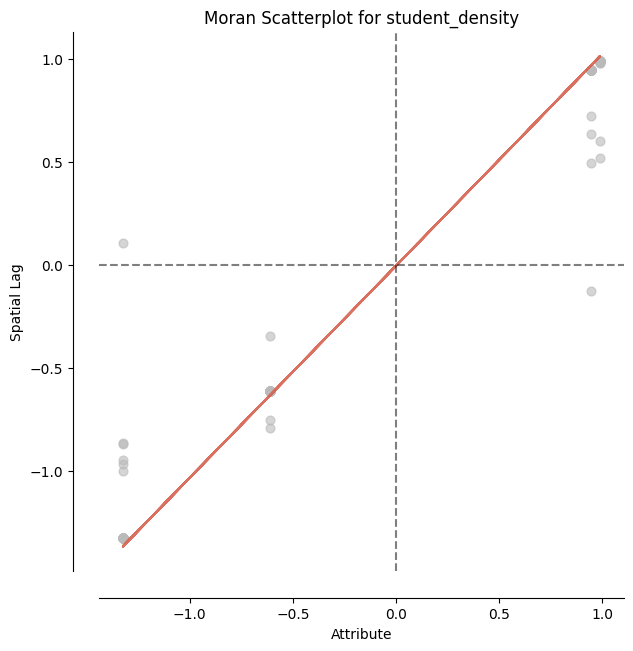

Moran's I for school_distance: 0.32244947529151835
P-value: 0.001



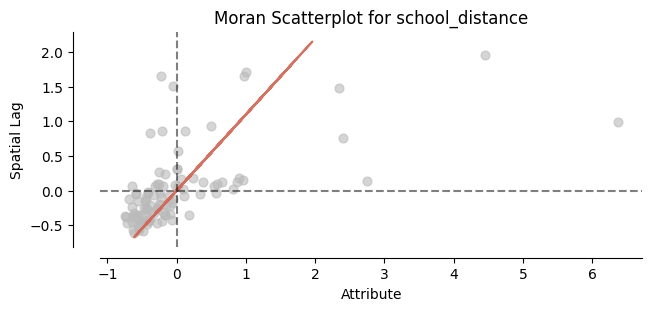

Moran's I for police_distance: 0.6353797241414102
P-value: 0.001



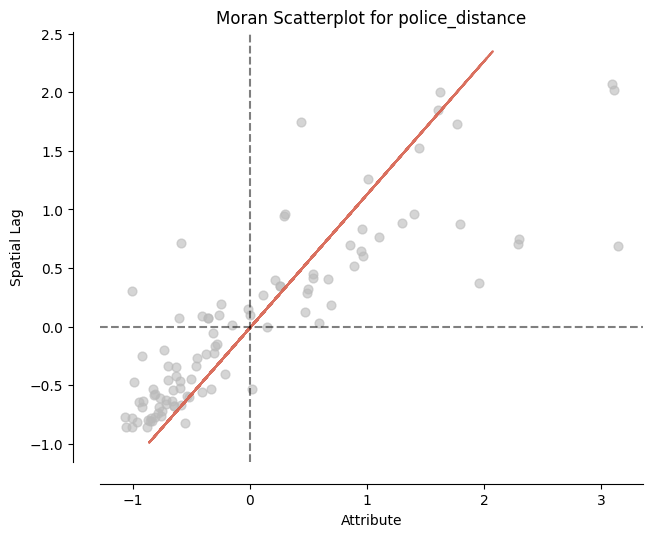

Moran's I for hospital_distance: 0.5541327202788261
P-value: 0.001



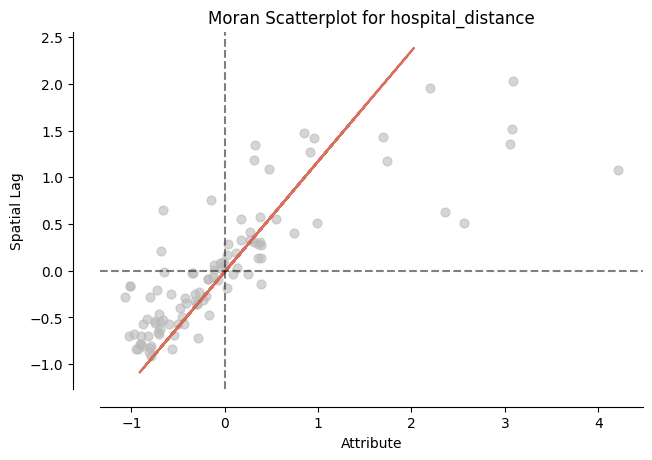

Moran's I for city_distance: 0.639539434724914
P-value: 0.001



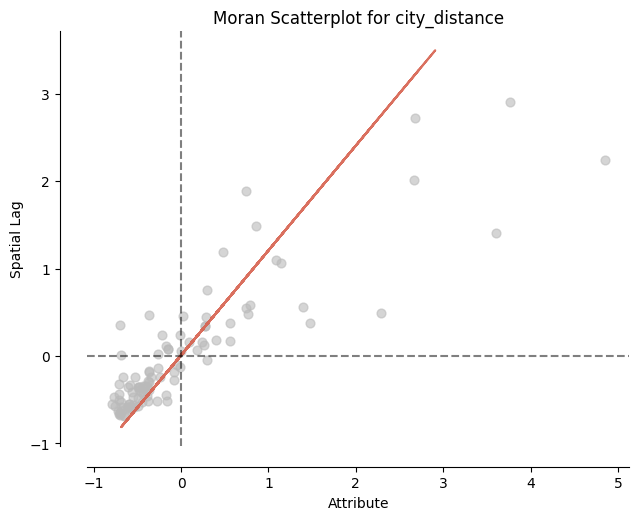

Moran's I for annual_precipitation: 0.9037524458792262
P-value: 0.001



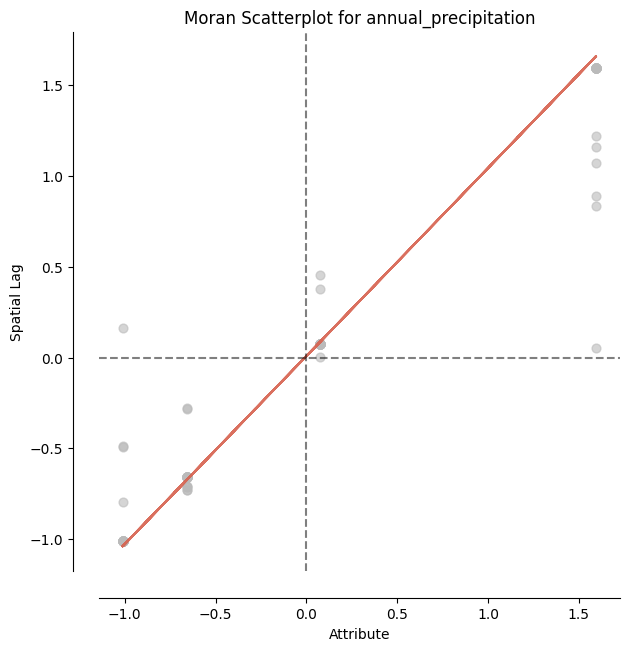

Moran's I for avg_high_temp: 0.9038294802100132
P-value: 0.001



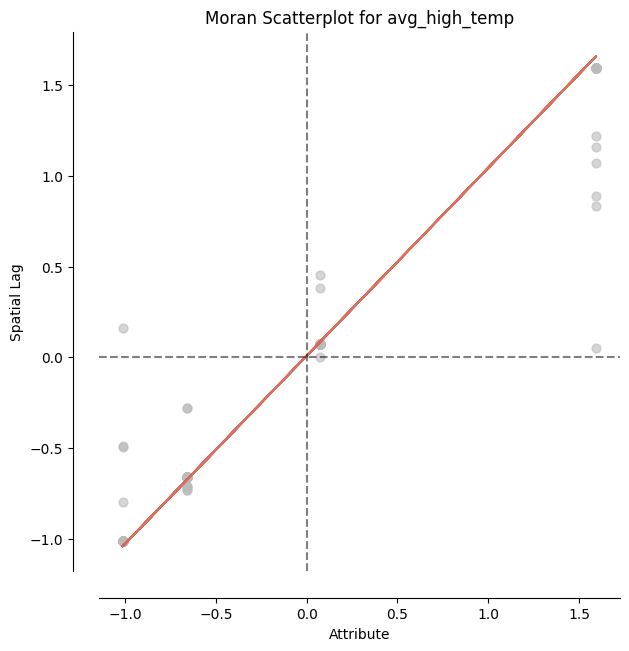

Moran's I for sunshine_hours: 0.9035727519911448
P-value: 0.001



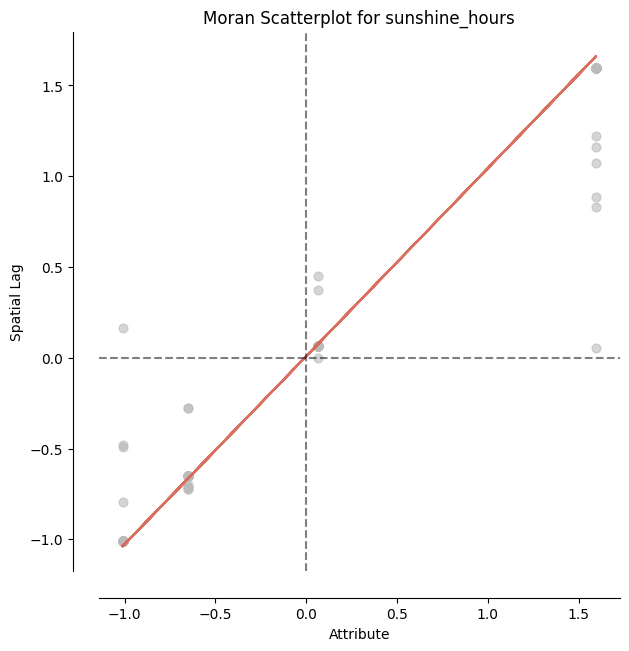

In [14]:
# Define spatial weights
w = weights.Queen.from_dataframe(location_geo_df, use_index=True)
w.transform = 'r'  # Row-standardization

# Variables for autocorrelation analysis
variables_of_autocorrelation = ['population_density', 'student_density', 'school_distance', 
                                'police_distance', 'hospital_distance', 'city_distance', 
                                'annual_precipitation', 'avg_high_temp', 'sunshine_hours']

# Calculate Moran's I for each variable
for variable in variables_of_autocorrelation:
    moran = esda.moran.Moran(location_geo_df[variable], w)
    print(f"Moran's I for {variable}: {moran.I}")
    print(f"P-value: {moran.p_sim}\n")

    # Plot Moran scatterplot
    moran_scatterplot(moran, aspect_equal=True)
    plt.title(f'Moran Scatterplot for {variable}')
    plt.show()
    

<H3>Spatial Distribution Analysis</H3>

This analysis conduct for population_density, student_density, annual_precipitation, avg_high_temp, sunshine_hours, school_distance, police_distance, hospital_distance, and city_distance columns.

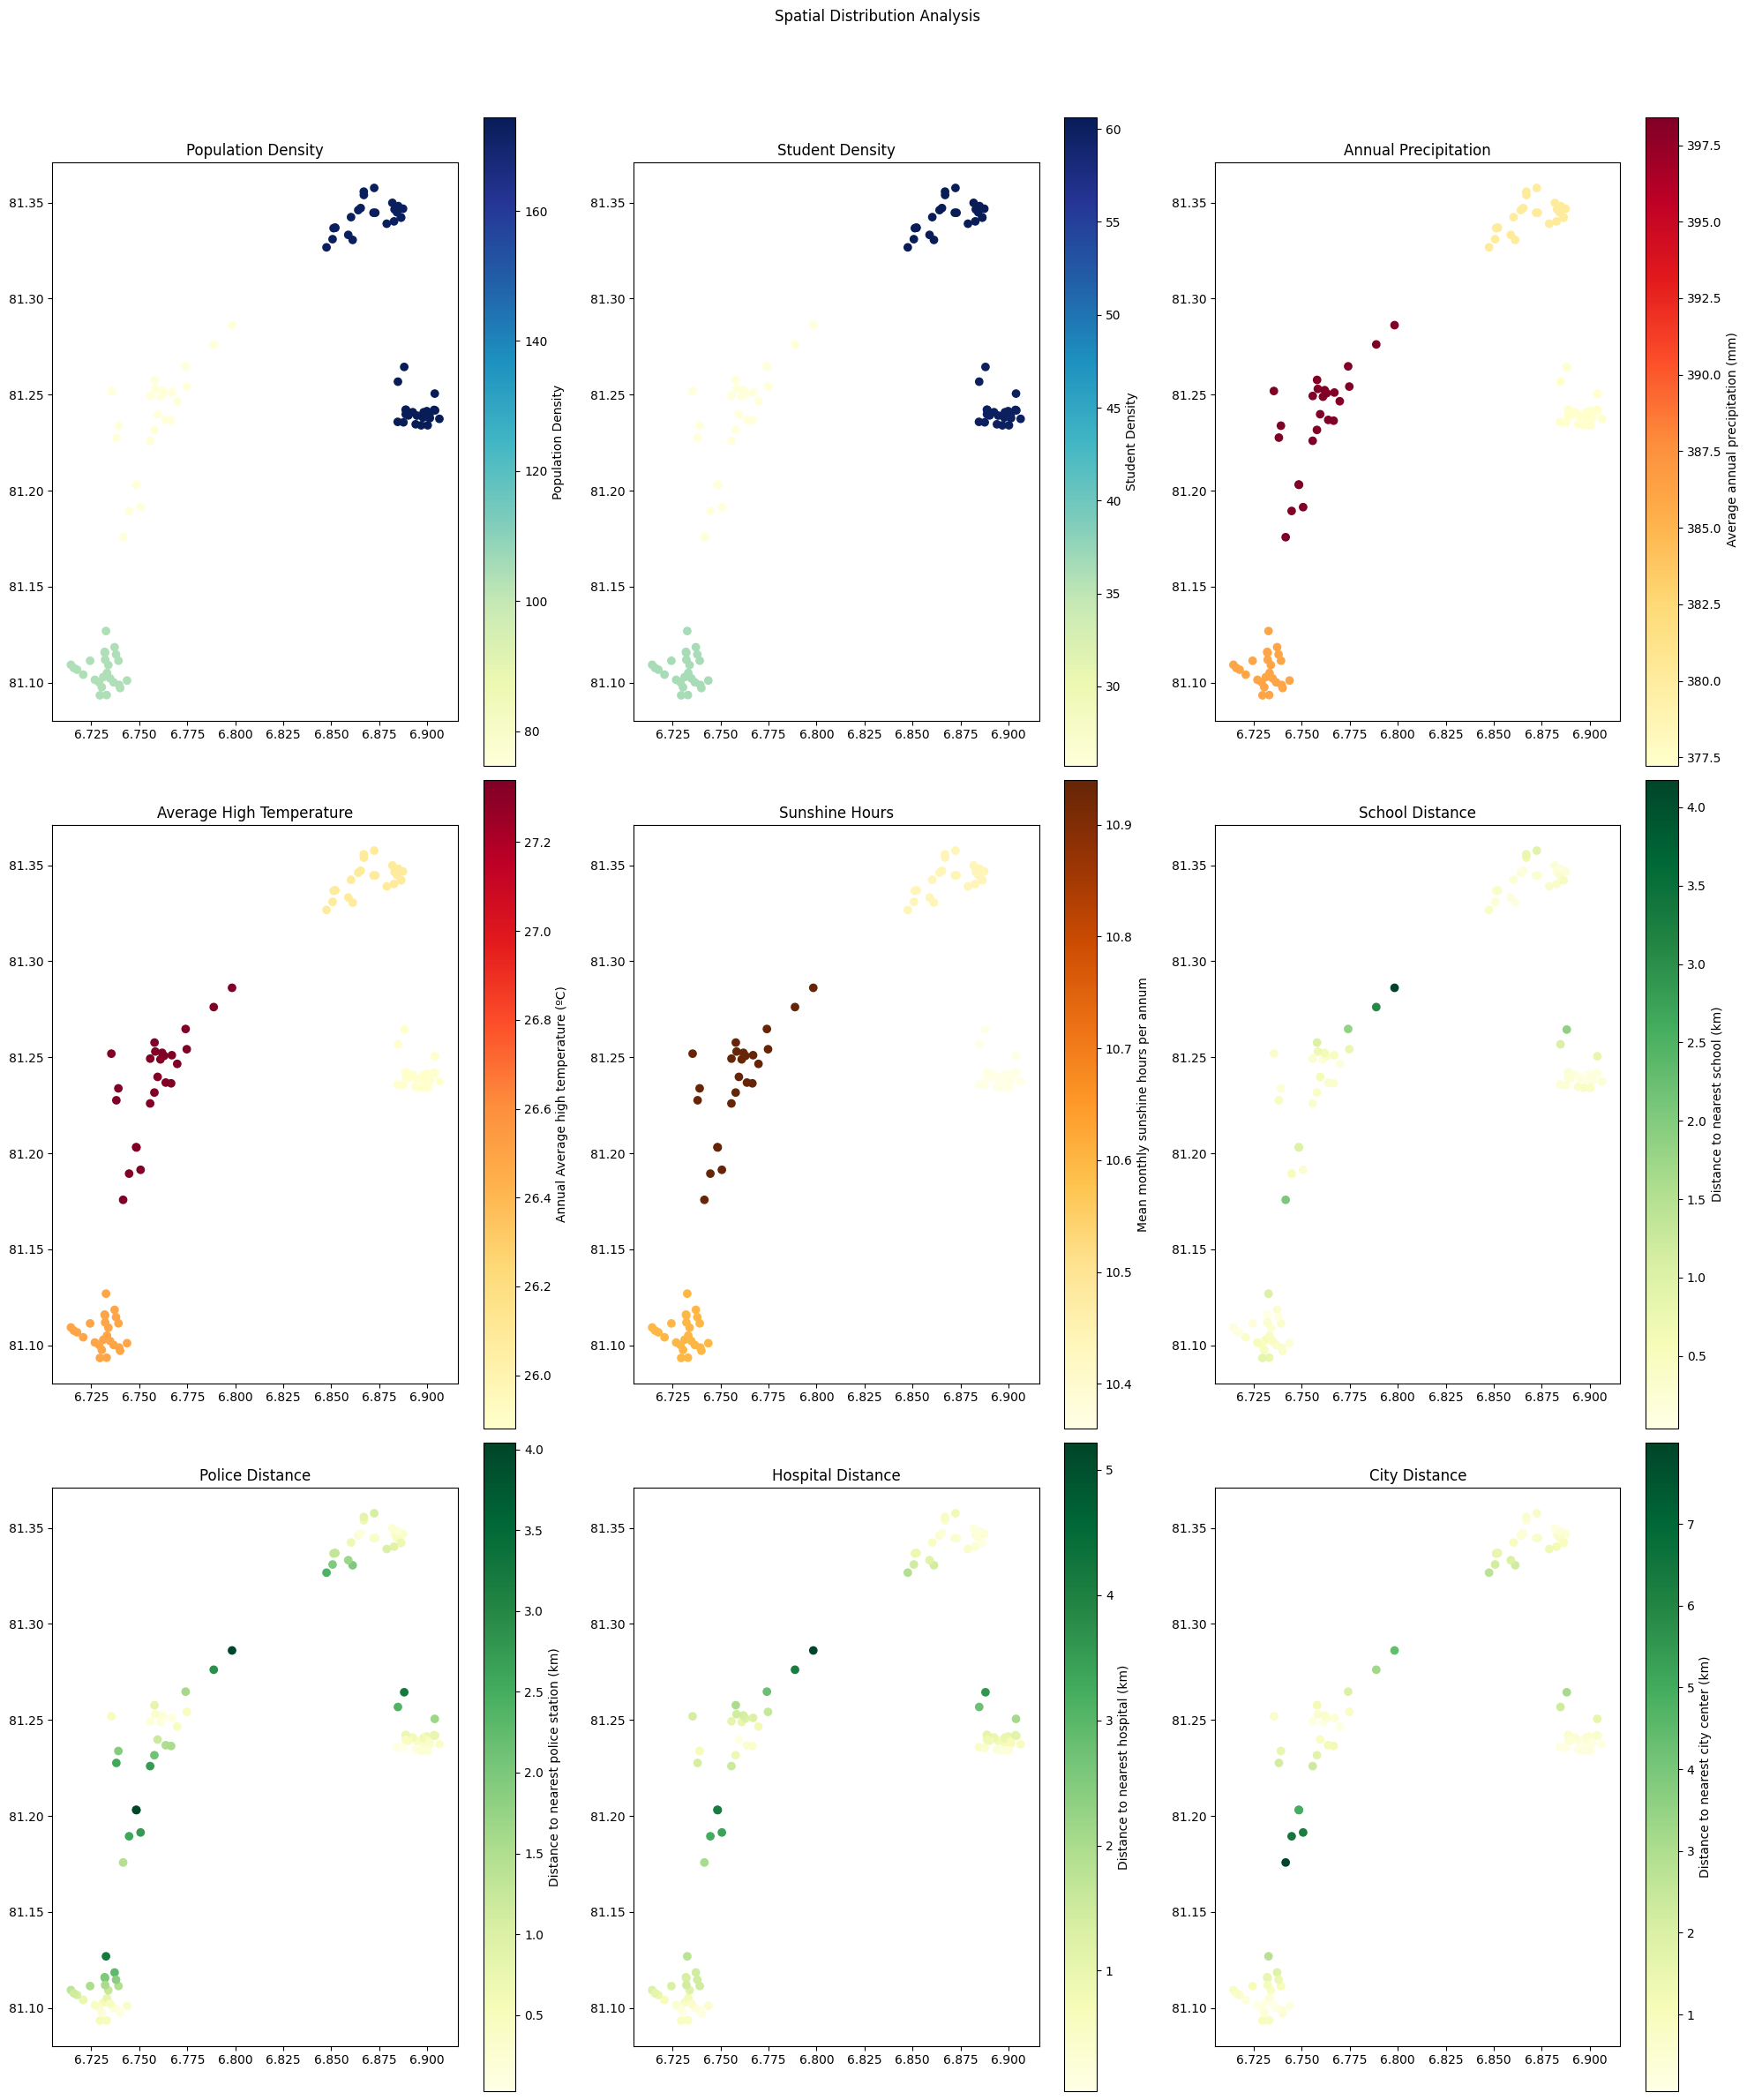

In [15]:
# Create choropleth maps for each variable
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))
fig.suptitle('Spatial Distribution Analysis')

# Population Density
ax = axes[0, 0]
location_geo_df.plot(column='population_density', cmap='YlGnBu', 
                     ax=ax, legend=True, legend_kwds={'label': "Population Density"})
ax.set_title('Population Density')

# Student Density
ax = axes[0, 1]
location_geo_df.plot(column='student_density', cmap='YlGnBu', 
                     ax=ax, legend=True, legend_kwds={'label': "Student Density"})
ax.set_title('Student Density')

# Annual Precipitation
ax = axes[0, 2]
location_geo_df.plot(column='annual_precipitation', cmap='YlOrRd', 
                     ax=ax, legend=True, legend_kwds={'label': " Average annual precipitation (mm)"})
ax.set_title('Annual Precipitation')

# Average High Temperature
ax = axes[1, 0]
location_geo_df.plot(column='avg_high_temp', cmap='YlOrRd', 
                     ax=ax, legend=True, legend_kwds={'label': "Annual Average high temperature (ºC)"})
ax.set_title('Average High Temperature')

# Sunshine Hours
ax = axes[1, 1]
location_geo_df.plot(column='sunshine_hours', cmap='YlOrBr', 
                     ax=ax, legend=True, legend_kwds={'label': "Mean monthly sunshine hours per annum"})
ax.set_title('Sunshine Hours')

# School Distance
ax = axes[1, 2]
location_geo_df.plot(column='school_distance', cmap='YlGn', 
                     ax=ax, legend=True, legend_kwds={'label': "Distance to nearest school (km)"})
ax.set_title('School Distance')

# Police Distance
ax = axes[2, 0]
location_geo_df.plot(column='police_distance', cmap='YlGn', 
                     ax=ax, legend=True, legend_kwds={'label': "Distance to nearest police station (km)"})
ax.set_title('Police Distance')

# Hospital Distance
ax = axes[2, 1]
location_geo_df.plot(column='hospital_distance', cmap='YlGn', 
                     ax=ax, legend=True, legend_kwds={'label': "Distance to nearest hospital (km)"})
ax.set_title('Hospital Distance')

# City Distance
ax = axes[2, 2]
location_geo_df.plot(column='city_distance', cmap='YlGn', 
                     ax=ax, legend=True, legend_kwds={'label': "Distance to nearest city center (km)"})
ax.set_title('City Distance')

# Remove empty subplot
# fig.delaxes(axes[2, 1])

# Show the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<H2>Spatial Feature Extraction and Feature Scaling</H2>

<H3> Scaling population_density, student_density, school_distance, and, sunshine_hours feature columns</H3>

The population_density, student_density, school_distance, and sunshine_hours columns should scale by assigning more weights to large values (Higher values are better to location selection).

Min-Max Scaling is use as a scaling technique.

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)

In [17]:
columns_to_new_df = ['location_id', 'division', 'longitude', 'latitude']

# Create a new DataFrame with the selected columns
new_locations_df = locations_df[columns_to_new_df].copy()

columns_to_scale_1 = ['population_density', 'student_density', 'school_distance', 'sunshine_hours']

# Scale the specified columns in the original DataFrame 
locations_df_scaled_1 = pd.DataFrame(scaler.fit_transform(locations_df[columns_to_scale_1]), columns=columns_to_scale_1)

# Concatenate the scaled columns into a new DataFrame
new_locations_df = pd.concat([new_locations_df, locations_df_scaled_1], axis=1)

print(new_locations_df.head())

new_locations_df.head()

  location_id division  longitude   latitude  population_density  \
0     lcn_001  buttala   6.761014  81.248930                 0.0   
1     lcn_002  buttala   6.762943  81.250759                 0.0   
2     lcn_003  buttala   6.769758  81.246575                 0.0   
3     lcn_004  buttala   6.757871  81.231635                 0.0   
4     lcn_005  buttala   6.755652  81.225967                 0.0   

   student_density  school_distance  sunshine_hours  
0              0.0         0.047635             1.0  
1              0.0         0.096961             1.0  
2              0.0         0.024123             1.0  
3              0.0         0.084622             1.0  
4              0.0         0.064811             1.0  


,location_id,division,longitude,latitude,population_density,student_density,school_distance,sunshine_hours
0,lcn_001,buttala,6.761014,81.248930,0.0,0.0,0.047635,1.0
1,lcn_002,buttala,6.762943,81.250759,0.0,0.0,0.096961,1.0
2,lcn_003,buttala,6.769758,81.246575,0.0,0.0,0.024123,1.0
3,lcn_004,buttala,6.757871,81.231635,0.0,0.0,0.084622,1.0
4,lcn_005,buttala,6.755652,81.225967,0.0,0.0,0.064811,1.0


<H3> Scaling police_distance, hospital_distance, and city_distance feature columns</H3>

The police_distance, hospital_distance, and city_distance columns should scale by assigning more weights to small values (Smaller values are better to location selection).

Min-Max Scaling is use as a scaling technique.

In [18]:
columns_to_scale_dist = ['police_distance', 'hospital_distance', 'city_distance']

# Perform inverse min-max scaling
def inverse_min_max_scale(data):
    min_val = data.min()
    max_val = data.max()
    return (max_val - data) / (max_val - min_val)

# Scale the specified columns in the original DataFrame
locations_df_scaled_dist = pd.DataFrame(scaler.fit_transform(locations_df[columns_to_scale_dist]), columns=columns_to_scale_dist)
locations_df_inverse_dist = locations_df_scaled_dist.apply(inverse_min_max_scale)

# Concatenate the scaled columns with the new DataFrame
new_locations_df = pd.concat([new_locations_df, locations_df_inverse_dist], axis=1)

print(new_locations_df.head())

  location_id division  longitude   latitude  population_density  \
0     lcn_001  buttala   6.761014  81.248930                 0.0   
1     lcn_002  buttala   6.762943  81.250759                 0.0   
2     lcn_003  buttala   6.769758  81.246575                 0.0   
3     lcn_004  buttala   6.757871  81.231635                 0.0   
4     lcn_005  buttala   6.755652  81.225967                 0.0   

   student_density  school_distance  sunshine_hours  police_distance  \
0              0.0         0.047635             1.0         0.965288   
1              0.0         0.096961             1.0         0.997526   
2              0.0         0.024123             1.0         0.895957   
3              0.0         0.084622             1.0         0.484133   
4              0.0         0.064811             1.0         0.326149   

   hospital_distance  city_distance  
0           0.811775       0.984555  
1           0.772028       0.958520  
2           0.857328       0.984648  
3     

<H3> Scaling annual_precipitation and avg_high_temp feature columns</H3>

annual_precipitation and avg_high_temp columns should scale by assigning more weights to small values (Smaller values are better to location selection).

Min-Max Scaling is use as a scaling technique.

In [19]:
columns_to_scale_weather = ['annual_precipitation', 'avg_high_temp']

# Scale the specified columns in the original DataFrame
locations_df_scaled_weather = pd.DataFrame(scaler.fit_transform(locations_df[columns_to_scale_weather]), columns=columns_to_scale_weather)
locations_df_inverse_weather = locations_df_scaled_weather.apply(inverse_min_max_scale)

# Concatenate the scaled columns with the new DataFrame
new_locations_df = pd.concat([new_locations_df, locations_df_inverse_weather], axis=1)

print(new_locations_df.head())

  location_id division  longitude   latitude  population_density  \
0     lcn_001  buttala   6.761014  81.248930                 0.0   
1     lcn_002  buttala   6.762943  81.250759                 0.0   
2     lcn_003  buttala   6.769758  81.246575                 0.0   
3     lcn_004  buttala   6.757871  81.231635                 0.0   
4     lcn_005  buttala   6.755652  81.225967                 0.0   

   student_density  school_distance  sunshine_hours  police_distance  \
0              0.0         0.047635             1.0         0.965288   
1              0.0         0.096961             1.0         0.997526   
2              0.0         0.024123             1.0         0.895957   
3              0.0         0.084622             1.0         0.484133   
4              0.0         0.064811             1.0         0.326149   

   hospital_distance  city_distance  annual_precipitation  avg_high_temp  
0           0.811775       0.984555                   0.0            0.0  
1       

<H3> Scaling dist_to_main_road feature column</H3>

dist_to_main_road is scaled using a custom scaling function which is based onthe distance.

if distance <= 100m then value = 1.0 </br>
else if 100m < distance <= 200m then value = 0.9 (Like wise custome scaling mechanism implemented)

In [20]:
# Define custom scaling function to scale the 'dist_to_main_road' column
def custom_scaling(dist_to_main_road):
    if dist_to_main_road <= 100:
        return 1.0
    elif 100 < dist_to_main_road <= 200:
        return 0.9
    elif 200 < dist_to_main_road <= 300:
        return 0.8
    elif 300 < dist_to_main_road <= 400:
        return 0.7
    elif 400 < dist_to_main_road <= 500:
        return 0.6
    elif 500 < dist_to_main_road <= 600:
        return 0.5
    elif 600 < dist_to_main_road <= 700:
        return 0.4
    elif 700 < dist_to_main_road <= 800:
        return 0.3
    elif 800 < dist_to_main_road <= 900:
        return 0.2
    elif 900 < dist_to_main_road <= 1000:
        return 0.1
    else:
        return 0.0

# Apply the custom scaling function to the 'dist_to_main_road' column
new_locations_df['dist_to_main_road'] = locations_df['dist_to_main_road'].apply(custom_scaling)

print(new_locations_df.head())

  location_id division  longitude   latitude  population_density  \
0     lcn_001  buttala   6.761014  81.248930                 0.0   
1     lcn_002  buttala   6.762943  81.250759                 0.0   
2     lcn_003  buttala   6.769758  81.246575                 0.0   
3     lcn_004  buttala   6.757871  81.231635                 0.0   
4     lcn_005  buttala   6.755652  81.225967                 0.0   

   student_density  school_distance  sunshine_hours  police_distance  \
0              0.0         0.047635             1.0         0.965288   
1              0.0         0.096961             1.0         0.997526   
2              0.0         0.024123             1.0         0.895957   
3              0.0         0.084622             1.0         0.484133   
4              0.0         0.064811             1.0         0.326149   

   hospital_distance  city_distance  annual_precipitation  avg_high_temp  \
0           0.811775       0.984555                   0.0            0.0   
1     

<H2>Spatial Cluster Analysis</H2>

Analyze the spatial distribution of schools, hospitals, and police stations to identify clusters.

Use spatial clustering algorithms (K-means Clustering) to group locations based on proximity to schools (school_distance), hospitals (hospital_distance), and police stations (police_distance). This can reveal areas with a high concentration of educational, healthcare, and security facilities.

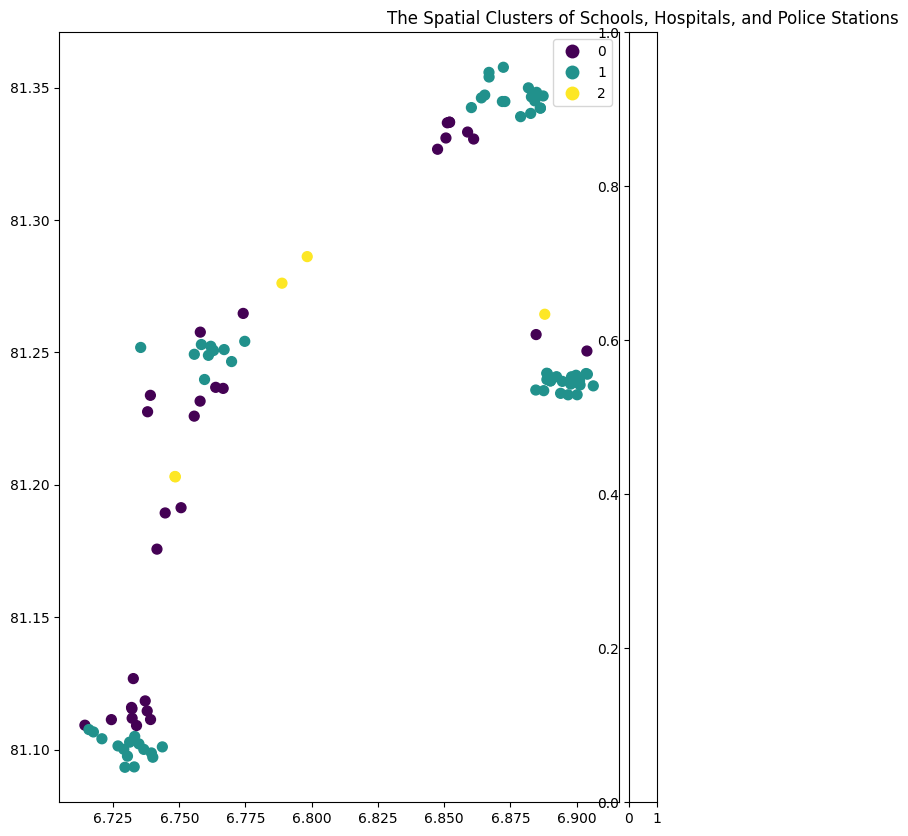

In [21]:

# Create a GeoDataFrame using longitude and latitude columns
location_geo_df = gpd.GeoDataFrame(new_locations_df, geometry=gpd.points_from_xy(new_locations_df.longitude, new_locations_df.latitude))

# Extracting the relevant features for clustering
features = location_geo_df[['school_distance', 'hospital_distance', 'police_distance']]

# Specify the number of clusters
num_clusters = 3

# Apply K-Means clustering algorithm
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
location_geo_df['cluster'] = kmeans.fit_predict(features)

# Visualize the clusters on a map
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the GeoDataFrame with clusters
location_geo_df.plot(column='cluster', categorical=True, legend=True, markersize=50, cmap='viridis', ax=ax)
# Add a colorbar to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# Get the colorbar from the axis
cbar = ax.get_figure().get_axes()[1]
cax.set_title('The Spatial Clusters of Schools, Hospitals, and Police Stations')
plt.show()

<H4>Visualize the cluster on map</H4>

In [22]:
# Create a Folium map centered on the mean latitude and longitude
map_clusters = folium.Map(location=[location_geo_df['longitude'].mean(), location_geo_df['latitude'].mean()], zoom_start=10)

# Define a color palette for the clusters
color_palette = ['red', 'blue', 'green']

# Add markers for each location with cluster information
for index, row in location_geo_df.iterrows():
    cluster_color = color_palette[row['cluster']]
    folium.Marker([row['longitude'], row['latitude']], popup=f"Cluster: {row['cluster']}", icon=folium.Icon(color=cluster_color)).add_to(map_clusters)

map_clusters

<H3>Define Weighted Metric to Calculate the Location Demand Score</H3>

In [23]:
# Weitage definition for each feature variables
feature_weights = {
    'population_density': 0.15,
    'student_density': 0.15,
    'dist_to_main_road': 0.1,
    'school_distance': 0.3,
    'police_distance': 0.05,
    'hospital_distance': 0.05,
    'city_distance': 0.1,
    'annual_precipitation': 0.04,
    'avg_high_temp': 0.03,
    'sunshine_hours': 0.03
}

# Calculate the weighted score by multiplying the feature values with the weights
new_locations_df['demand_score'] = (
    feature_weights['population_density'] * new_locations_df['population_density'] +
    feature_weights['student_density'] * new_locations_df['student_density'] +
    feature_weights['dist_to_main_road'] * new_locations_df['dist_to_main_road'] +
    feature_weights['school_distance'] * new_locations_df['school_distance'] +
    feature_weights['police_distance'] * new_locations_df['police_distance'] +
    feature_weights['hospital_distance'] * new_locations_df['hospital_distance'] +
    feature_weights['city_distance'] * new_locations_df['city_distance'] +
    feature_weights['annual_precipitation'] * new_locations_df['annual_precipitation'] +
    feature_weights['avg_high_temp'] * new_locations_df['avg_high_temp'] +
    feature_weights['sunshine_hours'] * new_locations_df['sunshine_hours']
)

print(new_locations_df.head())

  location_id division  longitude   latitude  population_density  \
0     lcn_001  buttala   6.761014  81.248930                 0.0   
1     lcn_002  buttala   6.762943  81.250759                 0.0   
2     lcn_003  buttala   6.769758  81.246575                 0.0   
3     lcn_004  buttala   6.757871  81.231635                 0.0   
4     lcn_005  buttala   6.755652  81.225967                 0.0   

   student_density  school_distance  sunshine_hours  police_distance  \
0              0.0         0.047635             1.0         0.965288   
1              0.0         0.096961             1.0         0.997526   
2              0.0         0.024123             1.0         0.895957   
3              0.0         0.084622             1.0         0.484133   
4              0.0         0.064811             1.0         0.326149   

   hospital_distance  city_distance  annual_precipitation  avg_high_temp  \
0           0.811775       0.984555                   0.0            0.0   
1     

In [24]:
new_locations_df.info()
new_locations_df
# save the new_locations_df to a csv file
new_locations_df.to_csv('data_files/new_locations_df.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   location_id           100 non-null    object 
 1   division              100 non-null    object 
 2   longitude             100 non-null    float64
 3   latitude              100 non-null    float64
 4   population_density    100 non-null    float64
 5   student_density       100 non-null    float64
 6   school_distance       100 non-null    float64
 7   sunshine_hours        100 non-null    float64
 8   police_distance       100 non-null    float64
 9   hospital_distance     100 non-null    float64
 10  city_distance         100 non-null    float64
 11  annual_precipitation  100 non-null    float64
 12  avg_high_temp         100 non-null    float64
 13  dist_to_main_road     100 non-null    float64
 14  demand_score          100 non-null    float64
dtypes: float64(13), object(2

<H2>Spatial Data Splitting</H2>

In [25]:
# Create a GeoDataFrame from the DataFrame
new_locations_gdf = gpd.GeoDataFrame(new_locations_df, geometry=gpd.points_from_xy(locations_df.longitude, locations_df.latitude))

feature variables = population_density, student_density, sunshine_hours, school_distance, police_distance, hospital_distance, city_distance, annual_precipitation, avg_high_temp, dist_to_main_road

target variable = demand_score

In [26]:
# Split the data into training and testing sets
X = new_locations_df.drop(['location_id', 'division', 'longitude', 'latitude', 'demand_score'], axis=1)
y = new_locations_df['demand_score']

# Split the data into training and testing sets with 20% of the data for testing and 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

<H2>Spatial Machine Learning Model Development and Training</H2>

RandomForestRegressor machine learning technique is applied.

The model prediction is a regression task. The choice of using RandomForestRegressor is based on the assumption that the relationship between the input features and the target variable is complex and nonlinear. 

In [27]:
# Create and train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42) 
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

<H3>Model Evaluation</H3>

Use Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and R-squared (R2) Score methods to evaluate the model.

In [28]:
# Evaluate the model performance using the test set
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

Mean Squared Error (MSE): 0.0026341888807915816
Root Mean Squared Error (RMSE): 0.051324349784401375
Mean Absolute Error (MAE): 0.026464998144515983
R-squared (R2) Score: 0.8568556589193524


<H3>Model Prediction</H3>

In [29]:
# Add predicted demand scores to the GeoDataFrame
new_locations_gdf['predicted_demand_score'] = model.predict(X)

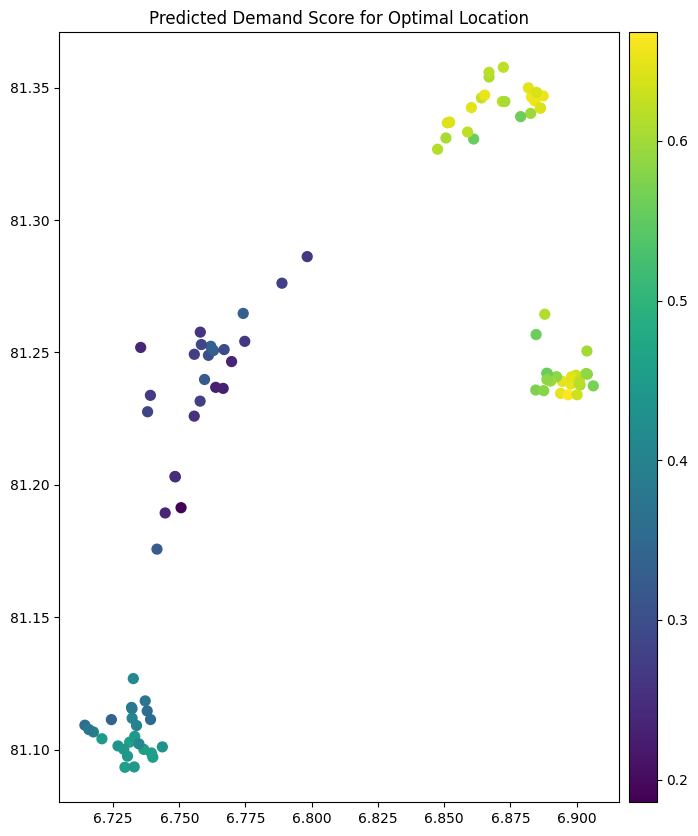

In [30]:
# Visualize the predictions using a choropleth map 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
new_locations_gdf['predicted_demand_score'] = model.predict(X)
new_locations_gdf.plot(column='predicted_demand_score', ax=ax, legend=True, cax=cax, cmap='viridis', markersize=50)
ax.set_title('Predicted Demand Score for Optimal Location')
plt.show()

# Visualize the predicted demand scores on a map
demand_map = folium.Map(location=[new_locations_gdf['longitude'].mean(), new_locations_gdf['latitude'].mean()], zoom_start=10)

# Add color coded markers for each location
for idx, row in new_locations_gdf.iterrows():
    if row['division'] == 'monaragala':
        color = 'red'
    elif row['division'] == 'buttala':
        color = 'blue'
    elif row['division'] == 'badalkumbura':
        color = 'green'
    else:
        color = 'orange'
    
    folium.Marker([row['longitude'], row['latitude']],
                  popup=f"Predicted Demand Score: {row['predicted_demand_score']}",
                  icon=folium.Icon(color=color)).add_to(demand_map)

# Save the map to an HTML file
demand_map.save('maps/predicted_demand_score_map.html')
demand_map

In [31]:
# Visualize the top five locations for establish a new school

# Get the top five locations
top_locations_df = new_locations_gdf.nlargest(5, 'predicted_demand_score') 

# Create a map centered around the mean latitude and longitude
school_map = folium.Map(location=[new_locations_gdf['longitude'].mean(), new_locations_gdf['latitude'].mean()], zoom_start=10)

# Define colors for markers
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Add a marker for each location to the map
for idx, row in top_locations_df.iterrows():
    color = colors.pop(0) if colors else 'gray'  # Use gray if there are more than 5 locations
    folium.Marker([row['longitude'], row['latitude']],
                   popup=f"Location: {row['latitude']:.4f}, {row['longitude']}<br>"
                        f"Predicted Demand Score: {row['predicted_demand_score']}",
                  icon=folium.Icon(color=color)).add_to(school_map)

# Save the map to an HTML file for better visualization
school_map.save('maps/top_school_locations_map.html')

# Output the top five locations with location_id as a table
print(top_locations_df[['location_id', 'division', 'longitude', 'latitude', 'predicted_demand_score']])

school_map

   location_id      division  longitude   latitude  predicted_demand_score
28     lcn_029  badalkumbura   6.896808  81.234022                0.667980
16     lcn_017    monaragala   6.882959  81.346501                0.657321
10     lcn_011    monaragala   6.884563  81.346753                0.655954
11     lcn_012    monaragala   6.887387  81.346851                0.654644
17     lcn_018    monaragala   6.884225  81.345002                0.653960
